In [ ]:
import pandas as pd
import matplotlib
import numpy as np

files = ['order_products__train.csv','orders.csv', 'order_products__prior.csv']
data = {}

for f in files:
    d = pd.read_csv('{0}'.format(f))
    data[f.replace('.csv','')] = d
#read data into dataframes    
prior = data['order_products__prior']
train = data['order_products__train']
orders = data['orders']
#creating product features
x=pd.DataFrame()
x['total']=prior.groupby('product_id').size()
x['reord']=prior.groupby('product_id').sum()['reordered']
x['reord_rate']=x['reord']/x['total']

orders.set_index('order_id', inplace=True, drop=False)
prior=prior.join(orders, on='order_id',rsuffix='.')
prior.drop('order_id.', inplace=True, axis=1)
#creating user features
userdata=pd.DataFrame()
userdata['mean_prior_time']=orders.groupby('user_id').mean()['days_since_prior_order']
userdata['basket']=prior.groupby('user_id')['product_id'].apply(set)
userdata['basketsize']=userdata['basket'].apply(len)
userdata['numord']=orders.groupby('user_id').size()
userdata['totitems']=prior.groupby('user_id').size()
userdata['av']=userdata['totitems']/userdata['numord']
#creating user*product features
prior['user_product'] = prior.product_id + prior.user_id * 50000
d= dict()
for row in prior.itertuples():
    if row.user_product not in d:
        d[row.user_product] = (1,(row.order_number, row.order_id),row.add_to_cart_order)
    else:
        d[row.user_product] = (d[row.user_product][0] + 1,max(d[row.user_product][1], (row.order_number, row.order_id)),d[row.user_product][2] + row.add_to_cart_order)
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['totorders', 'last_order_id', 'position']
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1])
userXproduct.position = userXproduct.position/userXproduct.totorders

traindat = orders[orders.eval_set == 'train']
train = data['order_products__train']
train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

label=[]
prodlist=[]
ordlist=[]
#creating labels
for i in traindat.itertuples():
    prod=userdata.basket[i.user_id]
    prodlist+=prod
    ordlist+=[i.order_id]*len(prod)
    label += [(i.order_id, product) in train.index for product in prod]
label = np.array(label, dtype=np.int8)
#creating the features matrix
df = pd.DataFrame({'oid':ordlist, 'pid':prodlist})
#userid
df['uid']=(df.oid.map(orders.user_id))
#totalnumber of orders for user
df['U_totalorders']=(df.uid.map(userdata.numord))
#total number of items for user
df['U_totitems']=(df.uid.map(userdata.totitems))
#average items in one order for user
df['U_averageitems']=(df.uid.map(userdata.av))
#total number of different items bought by user
df['U_basketsize']=(df.uid.map(userdata.basketsize))
#average time between purchases
df['U_meanpriortime']=(df.uid.map(userdata.mean_prior_time))
#time since user bought last order
df['U_since']=df.oid.map(orders.days_since_prior_order)
#ratio of time since user bought last order against his average
df['U_sinceratio']=df.U_since/df.U_meanpriortime
#the total number of orders that product appeared in
df['P_totalordertimes']=df.pid.map(x.total)
#total number of reorder times for product
df['P_reordtimes']=df.pid.map(x.reord)
#reorder rate for product
df['P_reorderrate']=df.pid.map(x.reord_rate)
#unique id for user product pair
df['UP_ID'] = df.uid * 50000 + df.pid
#total number of orders that user bought the product
df['UP_orders'] = df.UP_ID.map(userXproduct.totorders)
#ratio of total number of orders that user bought the product against total orders of the user
df['UP_orders_ratio'] = (df.UP_orders / df.U_totalorders)
#user's last order id that has the product in it
df['UP_last_order_id'] = df.UP_ID.map(userXproduct.last_order_id)
#the average position that user puts the product in cart
df['UP_average_pos_in_cart'] = (df.UP_ID.map(userXproduct.position))
#the reorder rate of the user buying the product
df['UP_reorder_rate'] = (df.UP_orders / df.U_totalorders)
#the number of orders since the user last bought the product
df['UP_orders_since_last'] = df.U_totalorders - df.UP_last_order_id.map(orders.order_number)


In [4]:
df2=df.copy()

In [5]:
df.drop(['uid','pid','oid','UP_last_order_id','UP_ID'], axis=1, inplace=True)

In [12]:
import sklearn.model_selection
#create test set and training set, we do not use the test set until the very last step
X_train, X_test, y_train, y_test=sklearn.model_selection.train_test_split(df,label,train_size=0.85)

C:\Users\Shengie\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
# X_train2, X_valid, y_train2, y_valid=sklearn.model_selection.train_test_split(X_train,y_train,train_size=0.85)
# dtrain = xgb.DMatrix(X_train2,label=y_train2)
# dvalid= xgb.DMatrix(X_valid,label=y_valid)

# for i in range(100):
#     mcw=random.randint(1,3)
#     gamma=random.randint(0,2)*1.0
#     subsample=random.randint(5,8)/8
#     colbt=random.randint(5,8)/8
#     maxdepth=random.randint(2,6)

#     params[ 'min_child_weight']=mcw
#     params['gamma']=gamma
#     params['subsample']=subsample
#     params[ 'colsample_bytree']=colbt
#     params['max_depth']=maxdepth

#     num_rounds = 200
#     watchlist  = [(dvalid,'valid'), (dtrain,'train')]
#     print(params,'\n')
#     bst = xgb.train(params, dtrain, num_rounds, watchlist)
#     print('+++++++++++++++++++++++++++++++++++++++++++++++\n')

#############Above is the parameter tuning process, we found the best params used below##########################






#cross-validating our model
import xgboost as xgb
for i in range(10):

    print("%dth Validation Process"%(i+1))
    #create valid set
    X_train2, X_valid, y_train2, y_valid=sklearn.model_selection.train_test_split(X_train,y_train,train_size=0.85)
    dtrain = xgb.DMatrix(X_train2,label=y_train2)
    dvalid= xgb.DMatrix(X_valid,label=y_valid)
    train_labels = dtrain.get_label()
    params = { 'max_depth':2,'eta':0.3, 'silent':1, 'objective':'binary:logistic','min_child_weight':1,'gamma':0,'subsample':1,'colsample_bytree':1}
    ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
    params['scale_pos_weight'] = ratio
    num_rounds = 200
    watchlist  = [(dvalid,'valid'), (dtrain,'train')]
    print(params,'\n')
    bst = xgb.train(params, dtrain, num_rounds, watchlist)

In [38]:
#performance on test set by using the parameters gotten above and the full training set
#note that we are only tracing the loss on the test set, we don't do any modifications to the model fropm this step
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest= xgb.DMatrix(X_test,label=y_test)
train_labels = dtrain.get_label()
params = { 'max_depth':2,'eta':0.3, 'silent':1, 'objective':'binary:logistic','min_child_weight':1,'gamma':0,'subsample':1,'colsample_bytree':1}
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio
num_rounds = 200
watchlist  = [(dtest,'test'), (dtrain,'train')]
print(params,'\n')
bst = xgb.train(params, dtrain, num_rounds, watchlist)

{'max_depth': 2, 'eta': 0.3, 'silent': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'gamma': 0, 'subsample': 1, 'colsample_bytree': 1, 'scale_pos_weight': 9.22549296554387} 

[0]	test-error:0.172219	train-error:0.172192
[1]	test-error:0.264758	train-error:0.264653
[2]	test-error:0.29335	train-error:0.293591
[3]	test-error:0.269486	train-error:0.269538
[4]	test-error:0.242402	train-error:0.242515
[5]	test-error:0.242402	train-error:0.242515
[6]	test-error:0.236569	train-error:0.236638
[7]	test-error:0.248986	train-error:0.24912
[8]	test-error:0.249624	train-error:0.249718
[9]	test-error:0.240006	train-error:0.24008
[10]	test-error:0.245515	train-error:0.245547
[11]	test-error:0.24653	train-error:0.246518
[12]	test-error:0.248057	train-error:0.248094
[13]	test-error:0.248218	train-error:0.248241
[14]	test-error:0.248082	train-error:0.248113
[15]	test-error:0.247199	train-error:0.247269
[16]	test-error:0.249392	train-error:0.249413
[17]	test-error:0.24905	train-error:0.249114

[174]	test-error:0.242922	train-error:0.243243
[175]	test-error:0.242952	train-error:0.243278
[176]	test-error:0.242772	train-error:0.243094
[177]	test-error:0.242719	train-error:0.243099
[178]	test-error:0.242794	train-error:0.24313
[179]	test-error:0.2429	train-error:0.243246
[180]	test-error:0.242827	train-error:0.24313
[181]	test-error:0.242851	train-error:0.243183
[182]	test-error:0.242845	train-error:0.24317
[183]	test-error:0.242908	train-error:0.243215
[184]	test-error:0.242939	train-error:0.243252
[185]	test-error:0.242924	train-error:0.243226
[186]	test-error:0.242899	train-error:0.243216
[187]	test-error:0.242895	train-error:0.243198
[188]	test-error:0.242893	train-error:0.243188
[189]	test-error:0.2428	train-error:0.243136
[190]	test-error:0.242679	train-error:0.242994
[191]	test-error:0.242743	train-error:0.243082
[192]	test-error:0.242832	train-error:0.243133
[193]	test-error:0.242969	train-error:0.243316
[194]	test-error:0.242967	train-error:0.243287
[195]	test-error:0.2

In [41]:
#get the auc score
preds = bst.predict(dtest)
from sklearn.metrics import roc_auc_score
result=roc_auc_score(np.squeeze(y_test),preds)
result

0.8292274732945848

In [47]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test+1, preds, pos_label=2)

In [51]:
import matplotlib.pyplot as plt

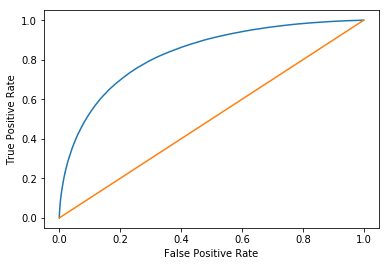

In [54]:
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
xx=np.linspace(0,1,num=50)
plt.plot(xx,xx)